In [1]:
import torch
from pathlib import Path
import numpy as np
import u_net, data_setup, utils, engine
import nibabel as nib


In [2]:
in_dir = Path.cwd()
target_dir = in_dir.parent / 'models'
target_dir.is_dir()

True

## 1. Load the metric data

In [3]:
train_loss = np.load(target_dir / 'train_loss.npy' )
train_metric = np.load(target_dir / 'train_metric.npy')
test_loss = np.load(target_dir / 'test_loss.npy')
test_metric = np.load(target_dir / 'test_metric.npy')

In [4]:
# Debug
(target_dir / 'train_loss.npy').is_file(),(target_dir / 'train_metric.npy').is_file(), (target_dir / 'test_loss.npy').is_file(), (target_dir / 'test_metric.npy').is_file()


(True, True, True, True)

## 2. Plot the metric data

<Figure size 640x480 with 0 Axes>

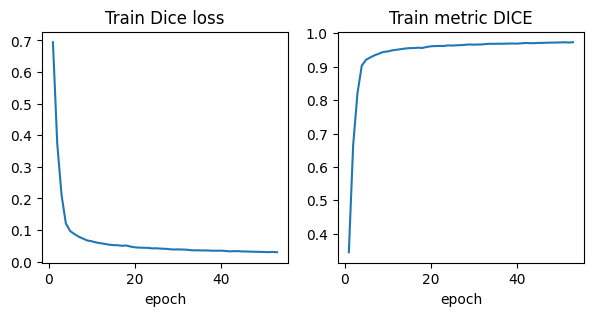

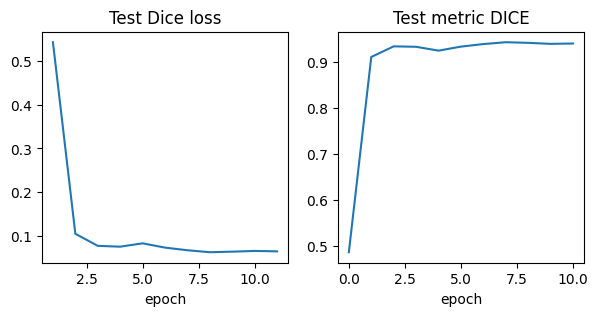

In [5]:
utils.plot_metric(train_loss = train_loss,
                  train_metric = train_metric,
                  test_loss = test_loss,
                  test_metric = test_metric)

### For visualization with TensorBoard, use "Tensorboard --logdir ..\runs" in the command line and open TensorBoard in your browser with "localhost:6007".

## 3. Plotting the prediction

### 3.1 Get the test data loader

In [3]:
_, test_dataloader = data_setup.prepare(in_dir = in_dir.parent / 'data',
                                        a_max = 300)

c:\Users\graumnitz\AppData\Local\anaconda3\envs\heart\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


### 3.2 Loading a pretrained model

In [4]:
num_classes = utils.number_of_classes(in_dir = in_dir.parent / 'data' / 'train_segmentations')
model, device = u_net.unet(num_classes = num_classes)
model.load_state_dict(torch.load(target_dir / 'ModelV9_diceloss.pth'))
model.eval()

[INFO] Number of classes: 8
Layer (type (var_name))                                                               Input Shape               Output Shape              Param #                   Trainable
UNet (UNet)                                                                           [1, 1, 128, 128, 64]      [1, 8, 128, 128, 64]      --                        True
├─Sequential (model)                                                                  [1, 1, 128, 128, 64]      [1, 8, 128, 128, 64]      --                        True
│    └─ResidualUnit (0)                                                               [1, 1, 128, 128, 64]      [1, 16, 64, 64, 32]       --                        True
│    │    └─Conv3d (residual)                                                         [1, 1, 128, 128, 64]      [1, 16, 64, 64, 32]       448                       True
│    │    └─Sequential (conv)                                                         [1, 1, 128, 128, 64]      [1, 16, 64

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


### 3.3 Get one dataset from the test dataloader

In [8]:
test_patient = next(iter(test_dataloader))
    

### 3.4 Make a prediction with the dataset on the model

In [9]:
prediction, output = engine.perform_inference(model = model,
                                              test_patient = test_patient)

[INFO]
Image shape: torch.Size([1, 1, 128, 128, 64])
Label shape: torch.Size([1, 1, 128, 128, 64])
Binary segmentation shape: torch.Size([1, 8, 128, 128, 64])
Multi segmentation shape: torch.Size([1, 1, 128, 128, 64])


### 3.5 Plot the prediction with matplotlib

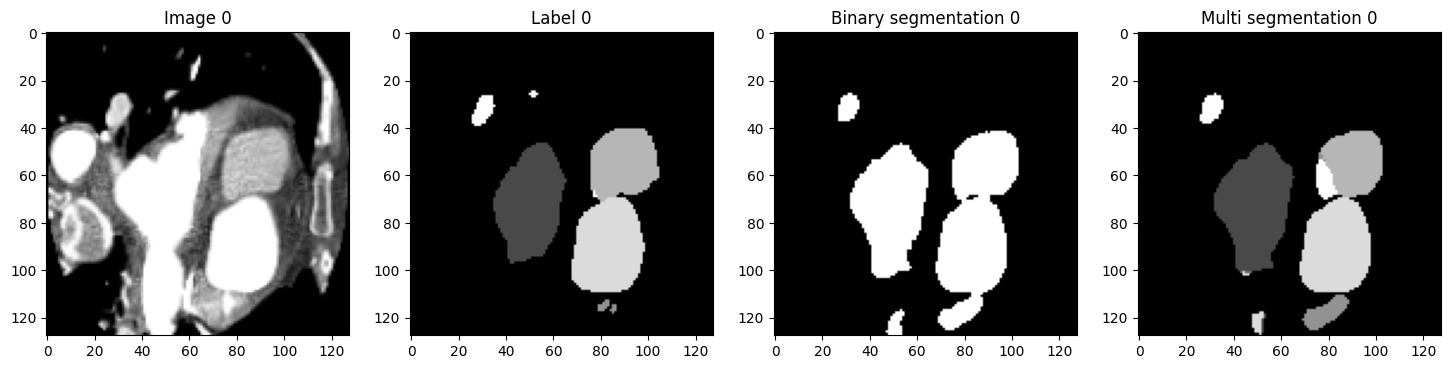

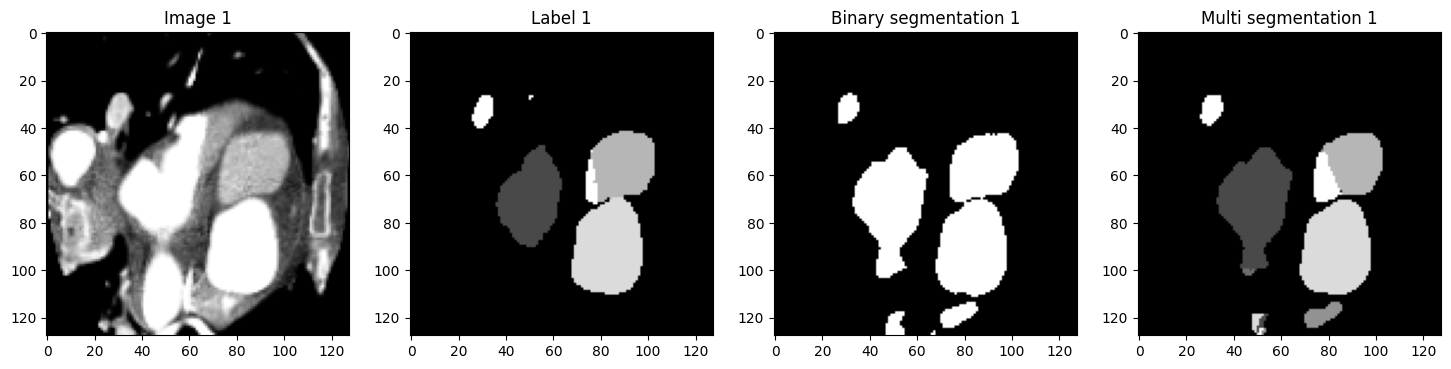

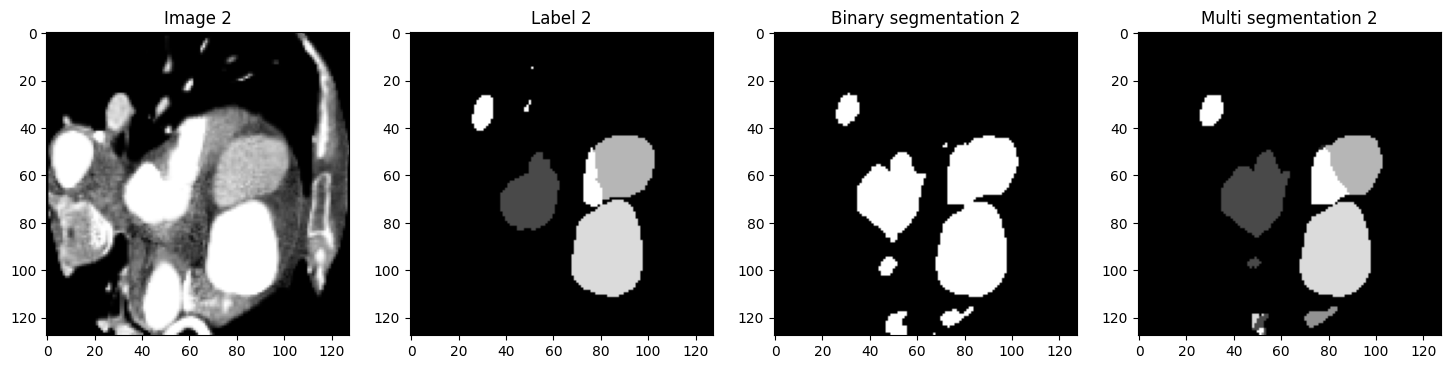

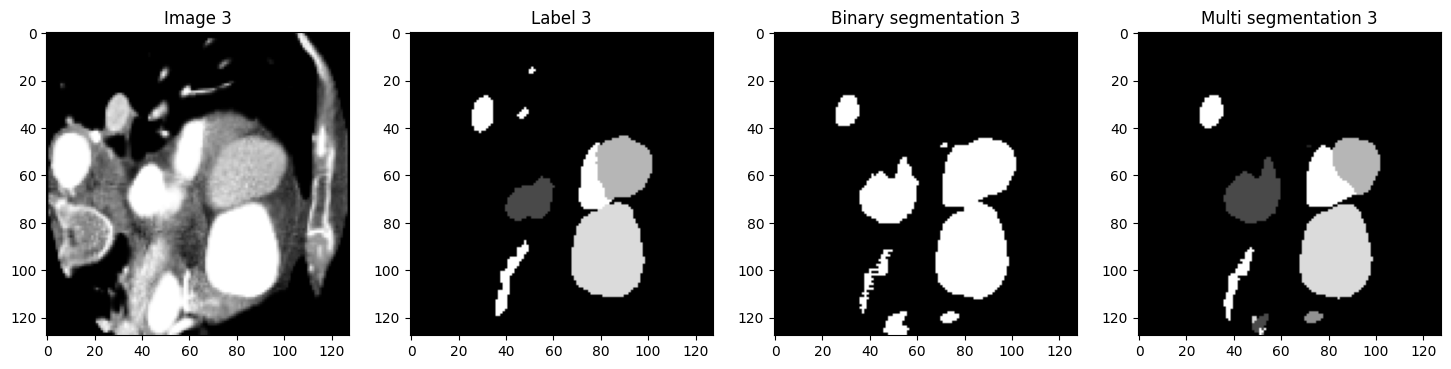

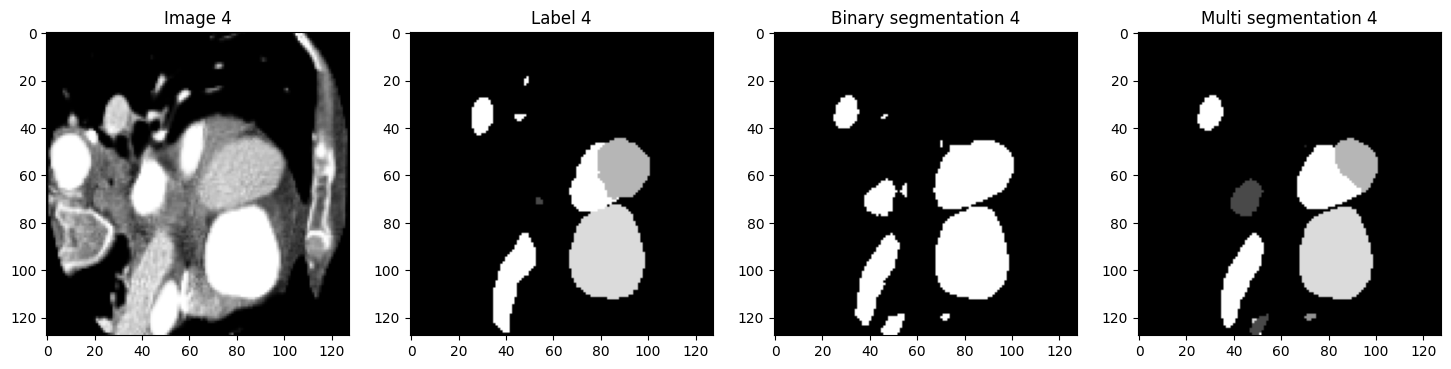

In [10]:
utils.plot_image_label_prediction(test_patient = test_patient,
                                  prediction = prediction,
                                  test_outputs = output)

## 4. Create a confusion matrix

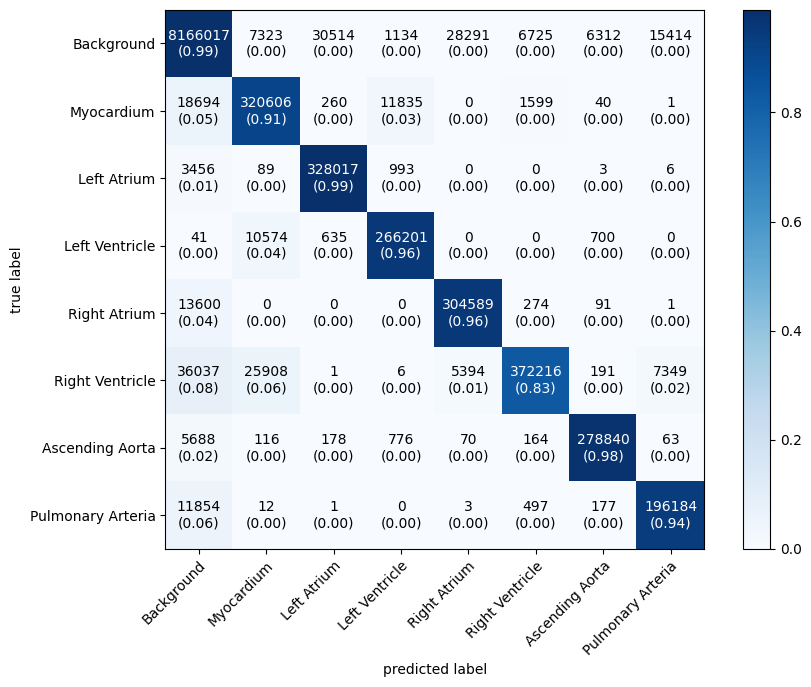

In [5]:
class_names = ['Background', 'Myocardium', 'Left Atrium', 'Left Ventricle', 'Right Atrium', 'Right Ventricle', 'Ascending Aorta', 'Pulmonary Arteria']

prediction_list = utils.plot_confusion_matrix(model = model,
                                              test_dataloader = test_dataloader,
                                              class_names = class_names)

## 5. Rescale the predictions

In [11]:

rescaled_predictions = utils.rescale_predictions(prediction_list = prediction_list,
                          file_path = (in_dir.parent / 'data' / 'test_segmentations').glob('*.nii.gz'))

[INFO] Length of prediction list: 10
[INFO] Number of Nifti files in directory: 10


10

## 6. Save the prediction as a nifti file

In [9]:
utils.save_nifti(prediction_list = rescaled_predictions,
                  out_dir = Path.cwd().parent)

[INFO] Saving prediction_0 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_1 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_2 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_3 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_4 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_5 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_6 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_7 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_8 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_9 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
